## Importing and prepping data

In [3]:
import pandas as pd

import diff_classifier.aws as aws
import diff_classifier.pca as pca

import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

In [4]:
features = []
#featofvar = 'Type and Serum'

remote_folder = '09_19_19_size_dependent_study_2' #Folder in AWS S3 containing files to be analyzed
bucket = 'mckenna.data'
vids = 5
types = ['40', '200']
slices = [1, 2, 3, 4]
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1']

counter = 0
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            try:
                filename = 'features_40YG_200red_{}_w{}_v{}.csv'.format(typ, slic, num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1")
                
                for extra in extras:
                    fstats[extra] = fstats.index
                fstats = fstats.drop(extras, axis=1)
                
                print('{} size: {}'.format(filename, fstats.shape))
                if '40' in typ:
                    fstats['Size'] = pd.Series(fstats.shape[0]*['40'], index=fstats.index)
                else:
                    fstats['Size'] = pd.Series(fstats.shape[0]*['200'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                fstats['Well Number'] = pd.Series(fstats.shape[0]*[slic], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))

features_40YG_200red_40_w1_v1.csv
features_40YG_200red_40_w1_v1.csv size: (100, 67)
features_40YG_200red_40_w1_v2.csv
features_40YG_200red_40_w1_v2.csv size: (124, 67)
features_40YG_200red_40_w1_v3.csv
features_40YG_200red_40_w1_v3.csv size: (125, 67)
features_40YG_200red_40_w1_v4.csv
features_40YG_200red_40_w1_v4.csv size: (128, 67)
features_40YG_200red_40_w1_v5.csv
features_40YG_200red_40_w1_v5.csv size: (123, 67)
features_40YG_200red_40_w2_v1.csv
features_40YG_200red_40_w2_v1.csv size: (43625, 67)
features_40YG_200red_40_w2_v2.csv
features_40YG_200red_40_w2_v2.csv size: (48830, 67)
features_40YG_200red_40_w2_v3.csv
features_40YG_200red_40_w2_v3.csv size: (50403, 67)
features_40YG_200red_40_w2_v4.csv
features_40YG_200red_40_w2_v4.csv size: (37810, 67)
features_40YG_200red_40_w2_v5.csv
features_40YG_200red_40_w2_v5.csv size: (41214, 67)
features_40YG_200red_40_w3_v1.csv
features_40YG_200red_40_w3_v1.csv size: (202, 67)
features_40YG_200red_40_w3_v2.csv
features_40YG_200red_40_w3_v2.cs

In [25]:
nonnum = ['Size', 'Well Number', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins', 'index']
nonnum = ['Size', 'Well Number', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins', 'index', 'Mean alpha', 'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis',
          'Std kurtosis', 'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2', 'Std asymmetry2', 'Mean asymmetry3',
          'Std asymmetry3', 'Mean AR', 'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness', 'Std boundedness',
          'Mean fractal_dim', 'Std fractal_dim', 'Mean trappedness', 'Std trappedness', 'Mean efficiency', 'Std efficiency',
          'Mean straightness', 'Std straightness', 'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames',
          'Mean Deff1', 'Std Deff1', 'Mean Deff2', 'Std Deff2']

## Train-Test Split

In [7]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [8]:
def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [9]:
f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [26]:
ncomp = 6
pcadataset = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.3594268701555632
1 component: 0.4956546974668392
2 component: 0.6105116172511819
3 component: 0.7124351229712363
4 component: 0.7723551204476937
5 component: 0.8249274111341001


In [27]:
pcadataset.prcomps

,0,1,2,3,4,5
0,asymmetry3,Deff1,D_fit,boundedness,Deff2,kurtosis
1,asymmetry2,straightness,alpha,trappedness,kurtosis,Deff2
2,asymmetry1,MSD_ratio,kurtosis,frames,Deff1,fractal_dim
3,elongation,elongation,frames,D_fit,straightness,D_fit
4,efficiency,asymmetry3,Deff1,straightness,efficiency,frames


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [28]:
pca_train = pcadataset

In [29]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

In [14]:
kmostat = pca.kmo(pca_train.scaled)

0.861911764708


## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [16]:
import numpy as np
featofvar = 'Size'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='40'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final[featofvar]=='200'].values[:, -ncomp:], axis=0)

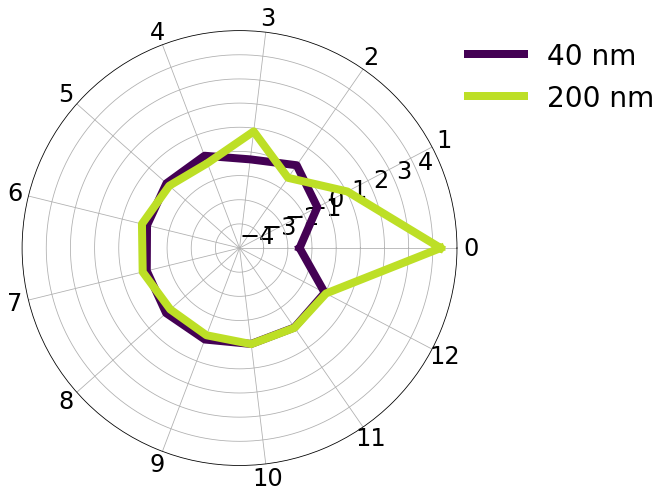

In [17]:
labels2 = ['40 nm', '200 nm']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-4, 4, 9), dpi=1200, labelsize=24,
             filename='pics/size_mixed_pcaavg.png')

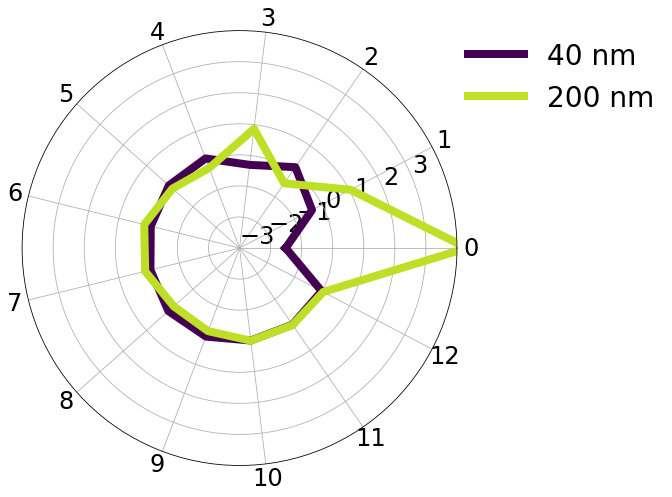

In [30]:
labels2 = ['40 nm', '200 nm']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-3, 3, 7), dpi=1200, labelsize=24,
             filename='pics/size_mixed_pcaavg_small.png')

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 2)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(loc='upper right', prop={'size': 18})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

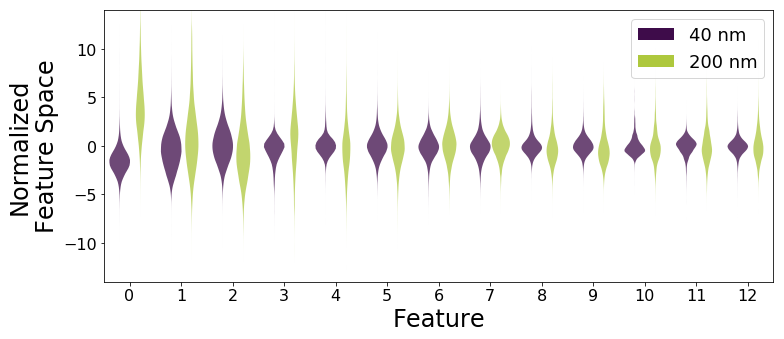

In [20]:
labels3 = ['40 nm', '200 nm']
labels = ['40', '200']
feats = feature_violin(pcadataset.final, label='Size', lvals=labels, labels=labels3, fsubset=ncomp, yrange=[-14, 14],
                       legendfontsize=18, labelsize=24, fname='./pics/size_mixed_pcadist.png')

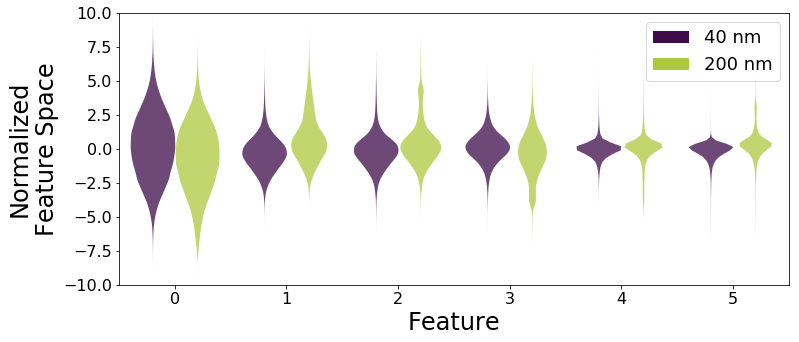

In [32]:
labels3 = ['40 nm', '200 nm']
labels = ['40', '200']
feats = feature_violin(pcadataset.final, label='Size', lvals=labels, labels=labels3, fsubset=ncomp, yrange=[-10, 10],
                       legendfontsize=18, labelsize=24, fname='./pics/size_mixed_pcadist_small.png')

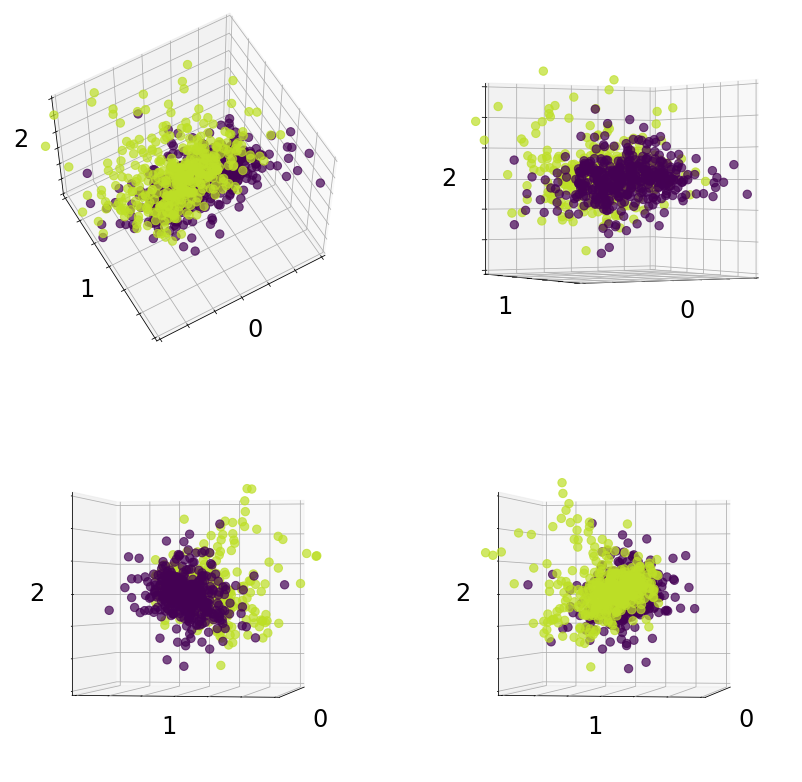

In [33]:
fstats1 = pca.feature_plot_3D(pca_train.final, label=featofvar, lvals=labels, randcount=400, ylim=[-6, 6],
                              xlim=[-6, 6], zlim=[-6, 6], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/size_mixed_3feats_small.png')

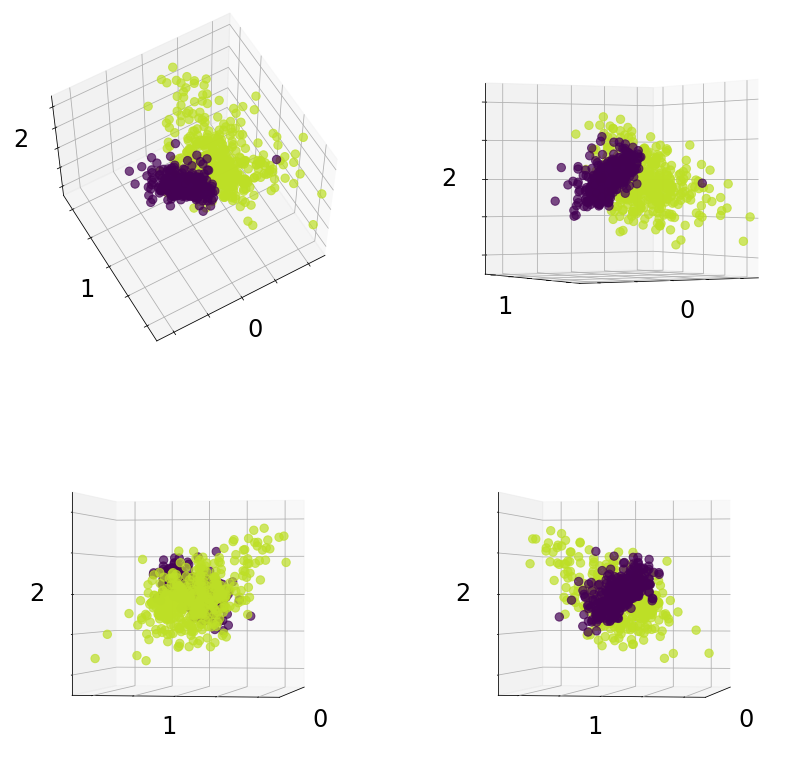

In [24]:
fstats1 = pca.feature_plot_3D(pca_train.final, label=featofvar, lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/size_mixed_3feats.png')

## Neural Network

In [22]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [23]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.03025119
Validation score: 0.994137
Iteration 2, loss = 0.01847747
Validation score: 0.994544
Iteration 3, loss = 0.01628358
Validation score: 0.995360
Iteration 4, loss = 0.01501316
Validation score: 0.995972
Iteration 5, loss = 0.01391899
Validation score: 0.995564
Iteration 6, loss = 0.01307303
Validation score: 0.995666
Iteration 7, loss = 0.01228083
Validation score: 0.995666
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 8, loss = 0.01142478
Validation score: 0.996431
Iteration 9, loss = 0.01121897
Validation score: 0.996482
Iteration 10, loss = 0.01107136
Validation score: 0.996533
Iteration 11, loss = 0.01093338
Validation score: 0.996533
Iteration 12, loss = 0.01081856
Validation score: 0.996482
Iteration 13, loss = 0.01068072
Validation score: 0.996686
Iteration 14, loss = 0.01055986
Validation score: 0.996686
Iteration 15, loss = 0.01045886
Validation score: 0.996482
Iterat

In [34]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.40073477
Validation score: 0.839137
Iteration 2, loss = 0.39212479
Validation score: 0.840769
Iteration 3, loss = 0.39085236
Validation score: 0.838780
Iteration 4, loss = 0.39018031
Validation score: 0.840412
Iteration 5, loss = 0.38959770
Validation score: 0.839851
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.001000
Iteration 6, loss = 0.38764300
Validation score: 0.842044
Iteration 7, loss = 0.38745155
Validation score: 0.842044
Iteration 8, loss = 0.38737595
Validation score: 0.841177
Iteration 9, loss = 0.38724363
Validation score: 0.841177
Validation score did not improve more than tol=0.000010 for two consecutive epochs. Setting learning rate to 0.000200
Iteration 10, loss = 0.38680738
Validation score: 0.841993
Iteration 11, loss = 0.38674929
Validation score: 0.842247
Iteration 12, loss = 0.38672218
Validation score: 0.841789
Iteration 13, loss = 0.38667333
Validation score: 0.841534
Iterat